# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




 # Amazon Fine Food Reviews Analysis_Clustering

# [1]. Reading Data

# Mounting Google Drive locally

In [74]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [76]:
# using SQLite Table to read data.
con = sqlite3.connect("/content/gdrive/My Drive/Dataset/database.sqlite") 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [78]:
print(display.shape)
display.head()

(80668, 7)


UserId  ... COUNT(*)
0  #oc-R115TNMSPFT9I7  ...        2
1  #oc-R11D9D7SHXIJB9  ...        3
2  #oc-R11DNU2NBKQ23Z  ...        2
3  #oc-R11O5J5ZVQE25C  ...        3
4  #oc-R12KPBODL2B5ZD  ...        2

[5 rows x 7 columns]

In [79]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId  ... COUNT(*)
80638  AZY10LLTJ71NX  ...        5

[1 rows x 7 columns]

In [80]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [81]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id  ...                                               Text
0   78445  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1  138317  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2  138277  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3   73791  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4  155049  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

[5 rows x 10 columns]

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [83]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [84]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [85]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id  ...                                               Text
0  64422  ...  My son loves spaghetti so I didn't hesitate or...
1  44737  ...  It was almost a 'love at first bite' - the per...

[2 rows x 10 columns]

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [87]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [88]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [89]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [90]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    
    return phrase

In [92]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [93]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [94]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [96]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2637.98it/s]


In [97]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [98]:
#Checking if there are any empty string
j=0
for i in preprocessed_reviews:
    
    if i == '':
        j+=1
        
print(j)

15


In [0]:
# Remove empty strings from list of strings
while("" in preprocessed_reviews) : 
    preprocessed_reviews.remove("")

In [100]:
# Cross checking if there are any empty string left
# not necessary
j=0
for i in preprocessed_reviews:
    
    if i == '':
        j+=1
        
print(j)

0


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [102]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4971, 12997)
the number of unique words  12997


In [103]:
final_counts.shape

(4971, 12997)

## [4.2] Bi-Grams and n-Grams.

In [104]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4971, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [105]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4971, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [107]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('greasy', 0.9935834407806396), ('alternative', 0.993563711643219), ('regular', 0.9933644533157349), ('original', 0.9930489659309387), ('snack', 0.9929217100143433), ('wonderful', 0.992552638053894), ('excellent', 0.9924169182777405), ('artificial', 0.9923770427703857), ('subtle', 0.9922462701797485), ('tasty', 0.9921879172325134)]
[('looks', 0.9995379447937012), ('remember', 0.9995275139808655), ('body', 0.999479353427887), ('level', 0.9994636178016663), ('de', 0.9994468688964844), ('course', 0.9994285106658936), ('normal', 0.9994076490402222), ('awful', 0.9994055032730103), ('idea', 0.9993983507156372), ('beef', 0.9993891716003418)]


In [108]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [109]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4971/4971 [00:04<00:00, 1147.30it/s]

4971
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [111]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4971/4971 [00:36<00:00, 135.39it/s]


# [5]  K-Means, Agglomerative & DBSCAN Clustering

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.cluster import KMeans

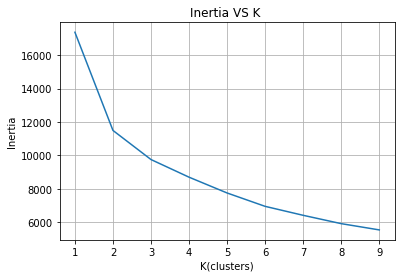

In [0]:
count_vect = CountVectorizer(min_df = 1000)
data=count_vect.fit_transform(preprocessed_reviews)
k=range(1,10)
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_init=20, n_jobs=-1)
    model.fit(data)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [0]:
#model.labels_ Labels of each point. It helps to create clusters of points
model.labels_.shape[0]

4971

In [0]:

model=KMeans(n_clusters=2, n_init=20, n_jobs=-1)
model.fit(data)
cluster_1 =[]
cluster_2 = []
for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    else :
        cluster_2.append(preprocessed_reviews[i])

print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 


cluster_1 has 1201 no. of points
cluster_2 has 3770 no. of points


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

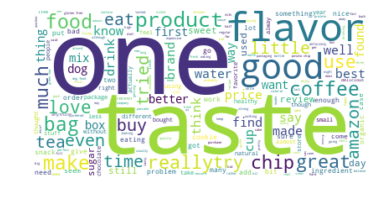

In [0]:
#for cluster_1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

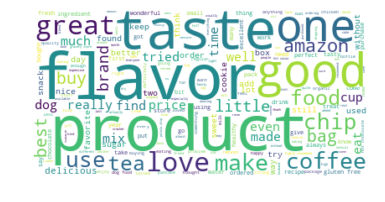

In [0]:
#for cluster_2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

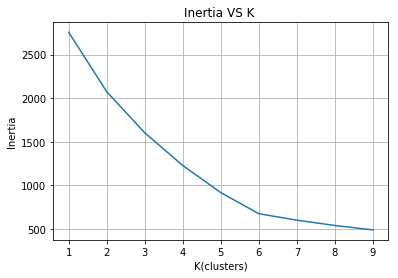

In [0]:
tfidf_vect = TfidfVectorizer(min_df = 1000)
data=tfidf_vect.fit_transform(preprocessed_reviews)
k=range(1,10)
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_init=20, n_jobs=-1)
    model.fit(data)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [0]:
model.labels_.shape[0]

4971

In [0]:
model.labels_

array([2, 0, 7, ..., 6, 2, 1], dtype=int32)

In [0]:

model=KMeans(n_clusters=6, n_init=20, n_jobs=-1)
model.fit(data)
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []
cluster_6 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    elif model.labels_[i]==2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i]==3:
        cluster_4.append(preprocessed_reviews[i])
    elif model.labels_[i]==4:
        cluster_5.append(preprocessed_reviews[i])       
    else :
        cluster_6.append(preprocessed_reviews[i])  


print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 
print(f"cluster_4 has {len(cluster_4)} no. of points") 
print(f"cluster_5 has {len(cluster_5)} no. of points") 
print(f"cluster_6 has {len(cluster_6)} no. of points")  

cluster_1 has 683 no. of points
cluster_2 has 1253 no. of points
cluster_3 has 923 no. of points
cluster_4 has 788 no. of points
cluster_5 has 572 no. of points
cluster_6 has 752 no. of points


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

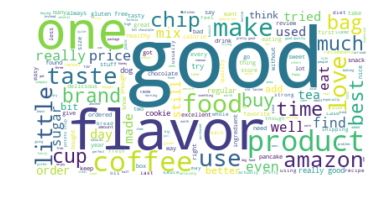

In [0]:
#for cluster_1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

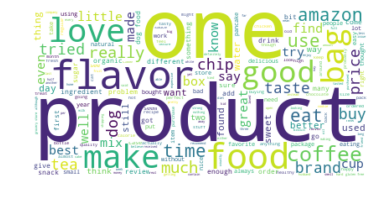

In [0]:
#for cluster_2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

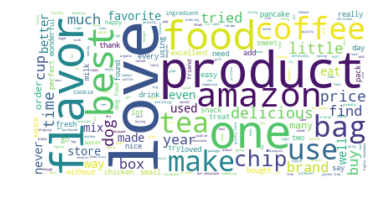

In [0]:
#for cluster_3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

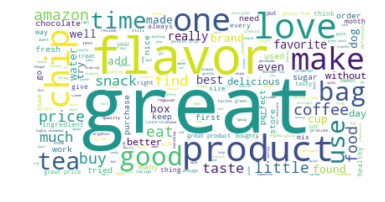

In [0]:
#for cluster_4
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

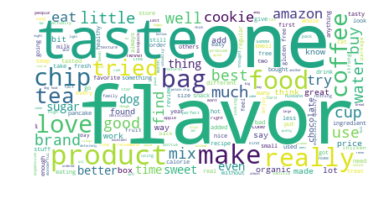

In [0]:
#for cluster_5
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

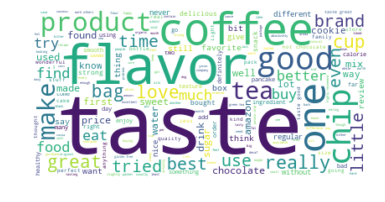

In [0]:
#for cluster_6
data=''
for i in cluster_6:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

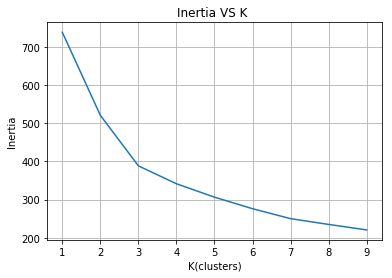

In [150]:
k=range(1,10)
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_init=20, n_jobs=-1)
    model.fit(sent_vectors)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [152]:
print("Number of cluster possible: len(set(model.labels_))")

Number of cluster possible: len(set(model.labels_))


In [153]:

model=KMeans(n_clusters=3, n_init=20, n_jobs=-1)
model.fit(sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    else:
        cluster_3.append(preprocessed_reviews[i])



print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 


cluster_1 has 2041 no. of points
cluster_2 has 1548 no. of points
cluster_3 has 1382 no. of points


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

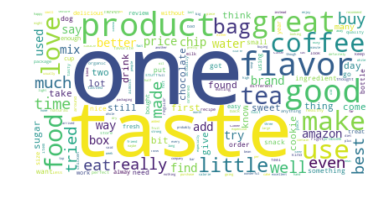

In [154]:
#for cluster_1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

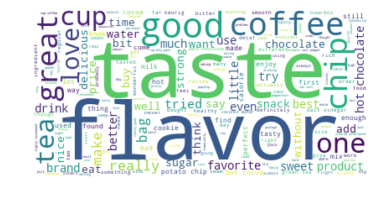

In [155]:
#for cluster_2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

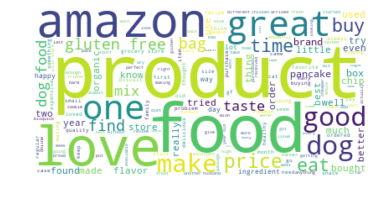

In [156]:
#for cluster_3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# tfidf_sent_vectors

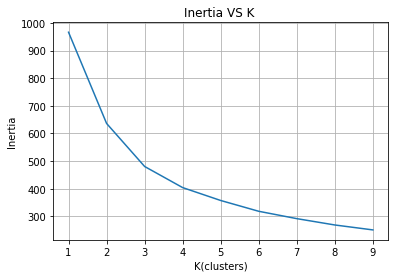

In [0]:
k=range(1,10)
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_init=20, n_jobs=-1)
    model.fit(tfidf_sent_vectors)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [0]:

model=KMeans(n_clusters=3, n_init=20, n_jobs=-1)
model.fit(tfidf_sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    else :
        cluster_3.append(preprocessed_reviews[i])




print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 



cluster_1 has 1655 no. of points
cluster_2 has 1892 no. of points
cluster_3 has 1424 no. of points


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

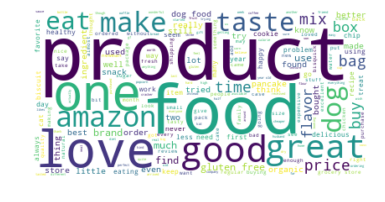

In [0]:
#for cluster_1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

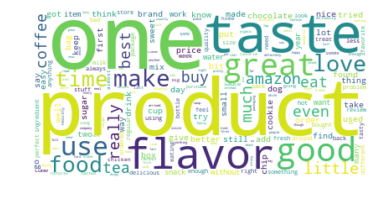

In [0]:
#for cluster_2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

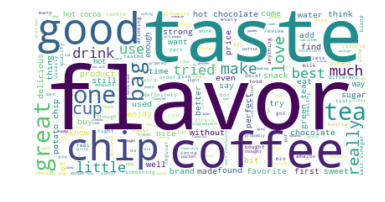

In [0]:
#for cluster_3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import AgglomerativeClustering as aggCluster

In [0]:
#--------------------For #clusters=2---------------------
model=aggCluster(n_clusters=2)
model.fit(sent_vectors)
cluster_1 = []
cluster_2 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    else:
        cluster_2.append(preprocessed_reviews[i]) 
    

print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 


cluster_1 has 3910 no. of points
cluster_2 has 1061 no. of points


In [0]:
#--------------------For #clusters=3---------------------
model=aggCluster(n_clusters=3)
model.fit(sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    else :
        cluster_3.append(preprocessed_reviews[i])




print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 



cluster_1 has 1769 no. of points
cluster_2 has 1061 no. of points
cluster_3 has 2141 no. of points


In [0]:
#--------------------For #clusters=5---------------------
model=aggCluster(n_clusters=5)
model.fit(sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    elif model.labels_[i]==2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i]==3:
        cluster_4.append(preprocessed_reviews[i])    
    else:
        cluster_5.append(preprocessed_reviews[i])



print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 
print(f"cluster_4 has {len(cluster_4)} no. of points") 
print(f"cluster_5 has {len(cluster_5)} no. of points") 



cluster_1 has 1968 no. of points
cluster_2 has 1061 no. of points
cluster_3 has 1346 no. of points
cluster_4 has 423 no. of points
cluster_5 has 173 no. of points


In [0]:
#--------------------For #clusters=6---------------------
model=aggCluster(n_clusters=6)
model.fit(sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []
cluster_6 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    elif model.labels_[i]==2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i]==3:
        cluster_4.append(preprocessed_reviews[i])  
    elif model.labels_[i]==4:
        cluster_5.append(preprocessed_reviews[i]) 
    else:
        cluster_6.append(preprocessed_reviews[i])



print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 
print(f"cluster_4 has {len(cluster_4)} no. of points") 
print(f"cluster_5 has {len(cluster_5)} no. of points") 
print(f"cluster_6 has {len(cluster_6)} no. of points") 




cluster_1 has 1355 no. of points
cluster_2 has 1061 no. of points
cluster_3 has 1346 no. of points
cluster_4 has 423 no. of points
cluster_5 has 173 no. of points
cluster_6 has 613 no. of points


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

--------------------For #clusters=2---------------------
Word cloud for cluster_1


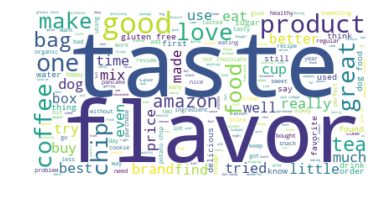

Word cloud for cluster_2


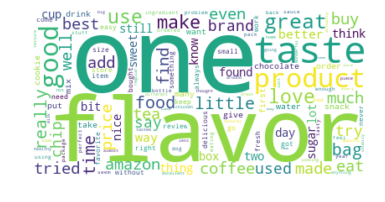

In [0]:
#for cluster_1
print("--------------------For #clusters=2---------------------")
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

--------------------For #clusters=3---------------------
Word cloud for cluster_1


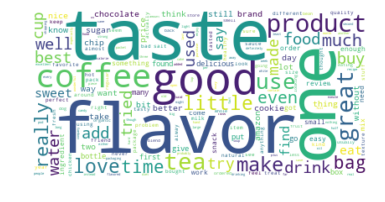

Word cloud for cluster_2


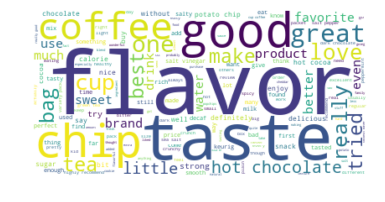

Word cloud for cluster_3


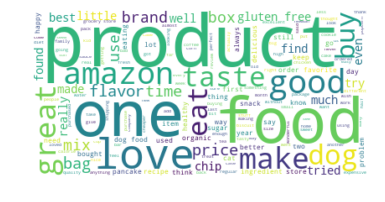

In [0]:
print("--------------------For #clusters=3---------------------")
#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

--------------------For #clusters=5---------------------
Word cloud for cluster_1


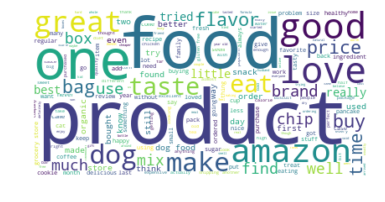

Word cloud for cluster_2


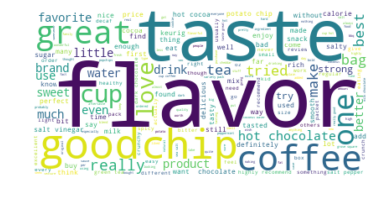

Word cloud for cluster_3


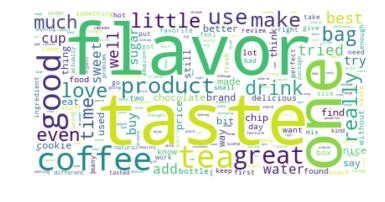

Word cloud for cluster_4


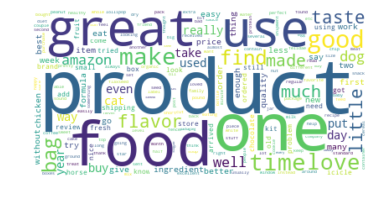

Word cloud for cluster_5


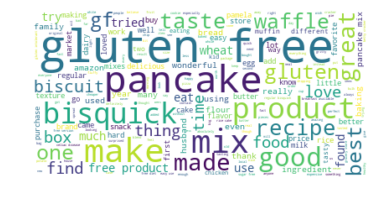

In [0]:
print("--------------------For #clusters=5---------------------")
#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_4
print("Word cloud for cluster_4")
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_5
print("Word cloud for cluster_5")
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

--------------------For #clusters=5---------------------
Word cloud for cluster_1


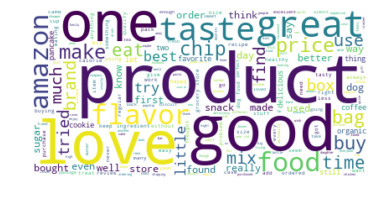

Word cloud for cluster_2


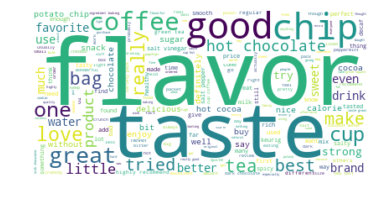

Word cloud for cluster_3


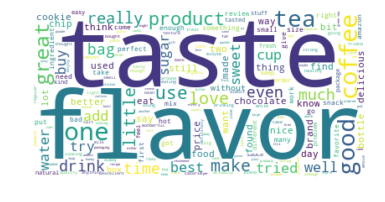

Word cloud for cluster_4


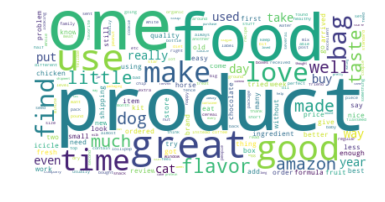

Word cloud for cluster_5


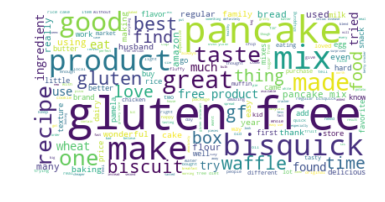

Word cloud for cluster_6


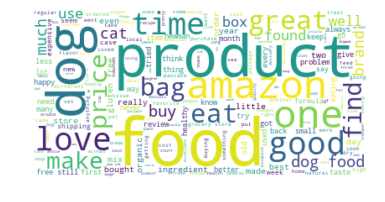

In [0]:
print("--------------------For #clusters=5---------------------")
#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_4
print("Word cloud for cluster_4")
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_5
print("Word cloud for cluster_5")
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_6
print("Word cloud for cluster_6")
data=''
for i in cluster_6:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
#--------------------For #clusters=2---------------------
model=aggCluster(n_clusters=2)
model.fit(tfidf_sent_vectors)
cluster_1 = []
cluster_2 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    else:
        cluster_2.append(preprocessed_reviews[i]) 
    

print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 


cluster_1 has 2580 no. of points
cluster_2 has 2391 no. of points


In [0]:
#--------------------For #clusters=3---------------------
model=aggCluster(n_clusters=3)
model.fit(tfidf_sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    else :
        cluster_3.append(preprocessed_reviews[i])




print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 



cluster_1 has 2391 no. of points
cluster_2 has 1650 no. of points
cluster_3 has 930 no. of points


In [0]:
#--------------------For #clusters=5---------------------
model=aggCluster(n_clusters=5)
model.fit(tfidf_sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    elif model.labels_[i]==2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i]==3:
        cluster_4.append(preprocessed_reviews[i])    
    else:
        cluster_5.append(preprocessed_reviews[i])



print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 
print(f"cluster_4 has {len(cluster_4)} no. of points") 
print(f"cluster_5 has {len(cluster_5)} no. of points") 



cluster_1 has 1614 no. of points
cluster_2 has 1954 no. of points
cluster_3 has 930 no. of points
cluster_4 has 437 no. of points
cluster_5 has 36 no. of points


In [0]:
#--------------------For #clusters=6---------------------
model=aggCluster(n_clusters=6)
model.fit(tfidf_sent_vectors)
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []
cluster_6 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    elif model.labels_[i]==2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i]==3:
        cluster_4.append(preprocessed_reviews[i])  
    elif model.labels_[i]==4:
        cluster_5.append(preprocessed_reviews[i]) 
    else:
        cluster_6.append(preprocessed_reviews[i])



print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 
print(f"cluster_4 has {len(cluster_4)} no. of points") 
print(f"cluster_5 has {len(cluster_5)} no. of points") 
print(f"cluster_6 has {len(cluster_6)} no. of points") 




cluster_1 has 1954 no. of points
cluster_2 has 730 no. of points
cluster_3 has 930 no. of points
cluster_4 has 437 no. of points
cluster_5 has 36 no. of points
cluster_6 has 884 no. of points


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

--------------------For #clusters=2---------------------
Word cloud for cluster_1


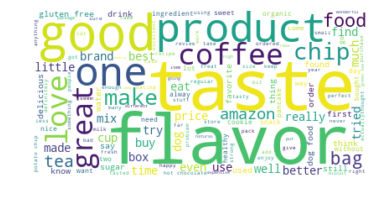

Word cloud for cluster_2


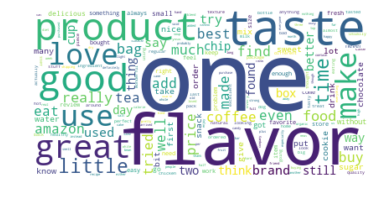

In [0]:
#for cluster_1
print("--------------------For #clusters=2---------------------")
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

--------------------For #clusters=3---------------------
Word cloud for cluster_1


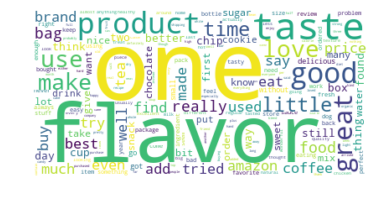

Word cloud for cluster_2


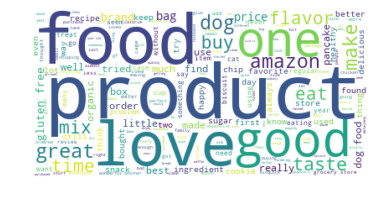

Word cloud for cluster_3


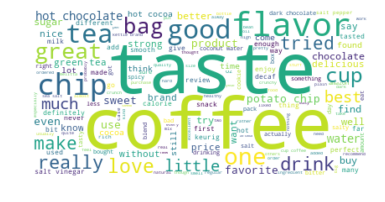

In [0]:
print("--------------------For #clusters=3---------------------")
#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

--------------------For #clusters=5---------------------
Word cloud for cluster_1


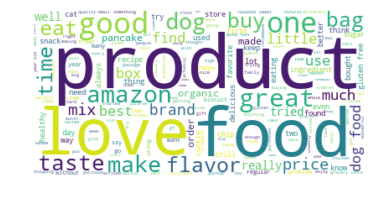

Word cloud for cluster_2


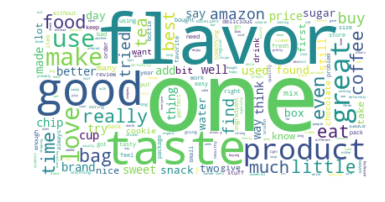

Word cloud for cluster_3


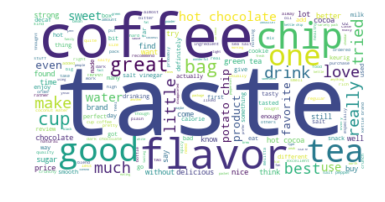

Word cloud for cluster_4


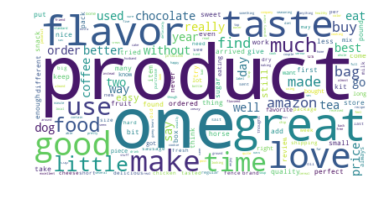

Word cloud for cluster_5


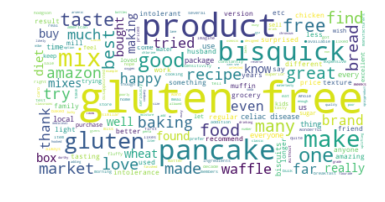

In [0]:
print("--------------------For #clusters=5---------------------")
#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_4
print("Word cloud for cluster_4")
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_5
print("Word cloud for cluster_5")
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

--------------------For #clusters=5---------------------
Word cloud for cluster_1


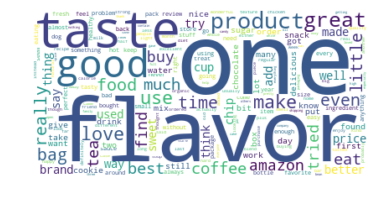

Word cloud for cluster_2


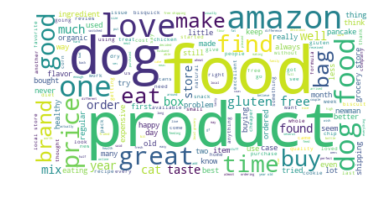

Word cloud for cluster_3


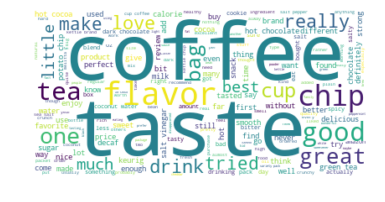

Word cloud for cluster_4


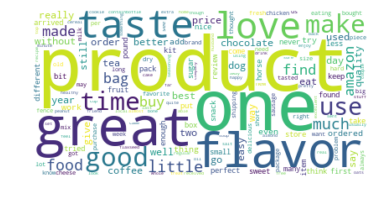

Word cloud for cluster_5


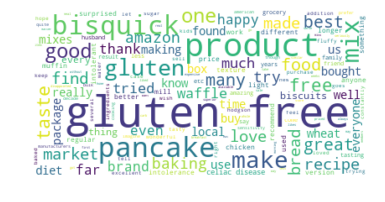

Word cloud for cluster_6


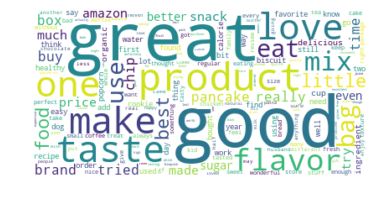

In [0]:
print("--------------------For #clusters=5---------------------")
#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_4
print("Word cloud for cluster_4")
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_5
print("Word cloud for cluster_5")
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_6
print("Word cloud for cluster_6")
data=''
for i in cluster_6:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import DBSCAN
import math 

In [113]:
#minpts = ln (n) Where ln= natural logarithm and n = no. Of data points
print (round(math.log(len(sent_vectors))))

9


In [0]:
#Standardize features by removing the mean and scaling to unit variance

#The standard score of a sample x is calculated as:

#z = (x - u) / s
#where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.
from sklearn.preprocessing import StandardScaler
data=StandardScaler().fit_transform(sent_vectors)

In [0]:
min_points = 9

#  taking the distance to the kth nearest neighbor from every point in the data
di=[]
for x in data:
    di.append(x[min_points])

di_sorted = di.sort() 
xi = [i for i in range(len(sent_vectors))]


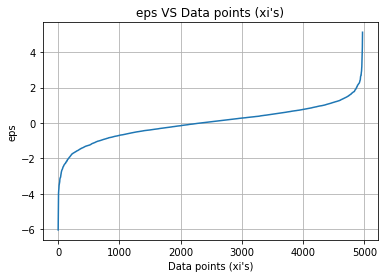

In [130]:
plt.plot(xi, di )
plt.xlabel("Data points (xi's)")
plt.ylabel('eps')
plt.title("eps VS Data points (xi's)")
plt.grid()
plt.show()

In [139]:

model=DBSCAN(eps=2,min_samples =9)
model.fit(data)

print(f"Number of Cluster present = {len(set(model.labels_))}")

cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []



for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i]) 
    elif model.labels_[i]==2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i]==3:
        cluster_4.append(preprocessed_reviews[i])    
    else:
        cluster_5.append(preprocessed_reviews[i])
    
print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 
print(f"cluster_4 has {len(cluster_4)} no. of points") 
print(f"cluster_5 has {len(cluster_5)} no. of points") 



Number of Cluster present = 5
cluster_1 has 2913 no. of points
cluster_2 has 8 no. of points
cluster_3 has 7 no. of points
cluster_4 has 7 no. of points
cluster_5 has 2036 no. of points


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

--------------------For #clusters=5---------------------
Word cloud for cluster_1


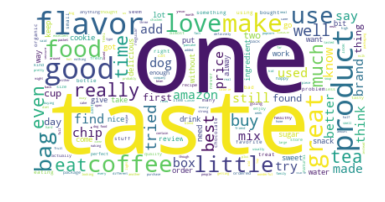

Word cloud for cluster_2


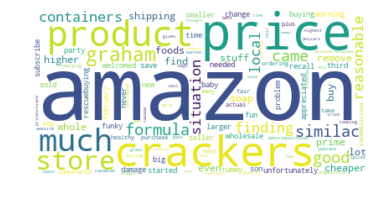

Word cloud for cluster_3


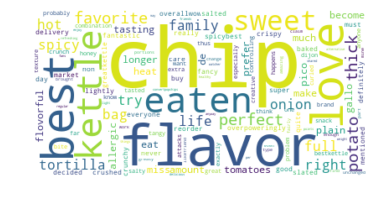

Word cloud for cluster_4


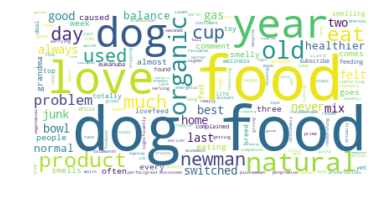

Word cloud for cluster_5


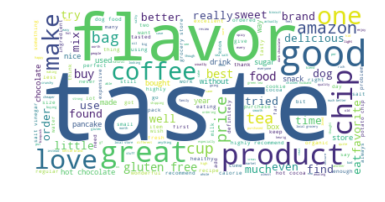

In [140]:
print("--------------------For #clusters=5---------------------")
#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_4
print("Word cloud for cluster_4")
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_5
print("Word cloud for cluster_5")
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [141]:
#minpts = ln (n) Where ln= natural logarithm and n = no. Of data points
print (round(math.log(len(tfidf_sent_vectors))))

9


In [0]:
#Standardize features by removing the mean and scaling to unit variance

#The standard score of a sample x is calculated as:

#z = (x - u) / s
#where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.
from sklearn.preprocessing import StandardScaler
data=StandardScaler().fit_transform(tfidf_sent_vectors)

In [0]:
min_points = 9

#  taking the distance to the kth nearest neighbor from every point in the data
di=[]
for x in data:
    di.append(x[min_points])

di_sorted = di.sort() 
xi = [i for i in range(len(tfidf_sent_vectors))]


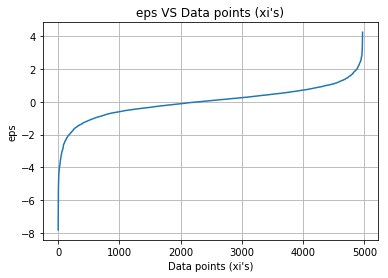

In [144]:
plt.plot(xi, di )
plt.xlabel("Data points (xi's)")
plt.ylabel('eps')
plt.title("eps VS Data points (xi's)")
plt.grid()
plt.show()

In [146]:

model=DBSCAN(eps=2,min_samples =9)
model.fit(data)

print(f"Number of Cluster present = {len(set(model.labels_))}")

cluster_1 = []
cluster_2 = []
cluster_3 = []



for i in range(model.labels_.shape[0]):
    if model.labels_[i]==0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i]==1:
        cluster_2.append(preprocessed_reviews[i])    
    else:
        cluster_3.append(preprocessed_reviews[i])
    
print(f"cluster_1 has {len(cluster_1)} no. of points") 
print(f"cluster_2 has {len(cluster_2)} no. of points") 
print(f"cluster_3 has {len(cluster_3)} no. of points") 



Number of Cluster present = 3
cluster_1 has 3637 no. of points
cluster_2 has 14 no. of points
cluster_3 has 1320 no. of points


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

--------------------For #clusters=5---------------------
Word cloud for cluster_1


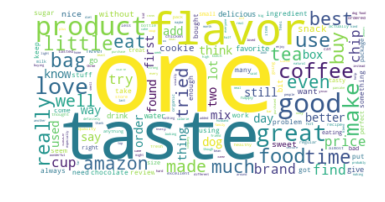

Word cloud for cluster_2


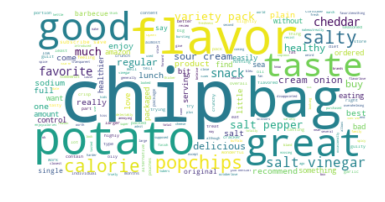

Word cloud for cluster_3


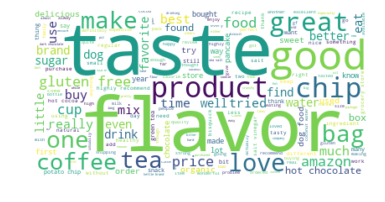

In [147]:

#for cluster_1
print("Word cloud for cluster_1")
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_2
print("Word cloud for cluster_2")
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_3
print("Word cloud for cluster_3")
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# [6] Conclusions

In [0]:
from prettytable import PrettyTable

In [163]:


x = PrettyTable(["Vectorizer", "Model",  "Best 'K'"])
y = PrettyTable(["Vectorizer", "Model", "Min Points" ,"Optimal eps", "Possible Cluster"])

print("PrettyTable for K-Means:")
x.add_row(["BoW", "KMeans" , 2 ])
x.add_row(["Tf-Idf", "KMeans" ,  6 ])
x.add_row(["AVG_W2V", "KMeans" ,  3])
x.add_row(["TFIDF_W2V", "KMeans" ,  3 ])

print(x)
print()


print("PrettyTable for DBSCAN:")
y.add_row(["AVG_W2V", "DBSCAN" , 9,2, 5])
y.add_row(["TFIDF_W2V", "DBSCAN" ,9,2, 3 ])
print(y)




PrettyTable for K-Means:
+------------+--------+----------+
| Vectorizer | Model  | Best 'K' |
+------------+--------+----------+
|    BoW     | KMeans |    2     |
|   Tf-Idf   | KMeans |    6     |
|  AVG_W2V   | KMeans |    3     |
| TFIDF_W2V  | KMeans |    3     |
+------------+--------+----------+

PrettyTable for DBSCAN:
+------------+--------+------------+-------------+------------------+
| Vectorizer | Model  | Min Points | Optimal eps | Possible Cluster |
+------------+--------+------------+-------------+------------------+
|  AVG_W2V   | DBSCAN |     9      |      2      |        5         |
| TFIDF_W2V  | DBSCAN |     9      |      2      |        3         |
+------------+--------+------------+-------------+------------------+
